In [1]:
import os
from glob import glob
import random
from pathlib import Path
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import json


from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from peft import LoraConfig, get_peft_model
from qwen_vl_utils import process_vision_info

In [2]:
# Set seed for reproducibility
random.seed(42)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA device name: {torch.cuda.get_device_name(device)}")

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


# Data Preparation

In [4]:
# Define paths and classes
DATASET_PATH = Path("../data/CDDM-images/images")
print(f"Dataset path: {DATASET_PATH}")
print(f"Exists: {DATASET_PATH.exists()}")

# Dynamically generate CLASSES from folder names
CLASSES = [folder.name for folder in DATASET_PATH.iterdir() if folder.is_dir()]

# Filter for Wheat classes only
CLASSES = [cls for cls in CLASSES if cls.startswith("Wheat,")]
CLASSES.sort()  # Sort for consistency
print(f"Classes: {CLASSES}")

if not CLASSES:
    raise ValueError("No classes found for Wheat. Check the dataset path and folder names.")

CLASS_TO_LABEL = {cls: idx for idx, cls in enumerate(CLASSES)}
LABEL_TO_CLASS = {idx: cls for idx, cls in enumerate(CLASSES)}

# Function to load image paths and labels
def load_dataset(dataset_path, classes):
    image_paths = []
    labels = []
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(CLASS_TO_LABEL[cls])
    return image_paths, labels

# Load the dataset
image_paths, labels = load_dataset(DATASET_PATH, CLASSES)

# Split into train and test sets (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Loaded {len(train_paths)} training samples and {len(test_paths)} test samples.")

Dataset path: ..\data\CDDM-images\images
Exists: True
Classes: ['Wheat,Healthy', 'Wheat,LeafRust', 'Wheat,LooseSmut', 'Wheat,RootRot', 'Wheat,SeptoriaLeafSpot', 'Wheat,StemRust', 'Wheat,StripeRust']
Loaded 4743 training samples and 1186 test samples.


Dataset path: ..\data\CDDM-images\images
Exists: True
Classes: ['Wheat,Healthy', 'Wheat,LeafRust', 'Wheat,LooseSmut', 'Wheat,RootRot', 'Wheat,SeptoriaLeafSpot', 'Wheat,StemRust', 'Wheat,StripeRust']
Total number of images: 5929
Vertical bar chart saved as 'wheat_class_distribution_vertical.png'


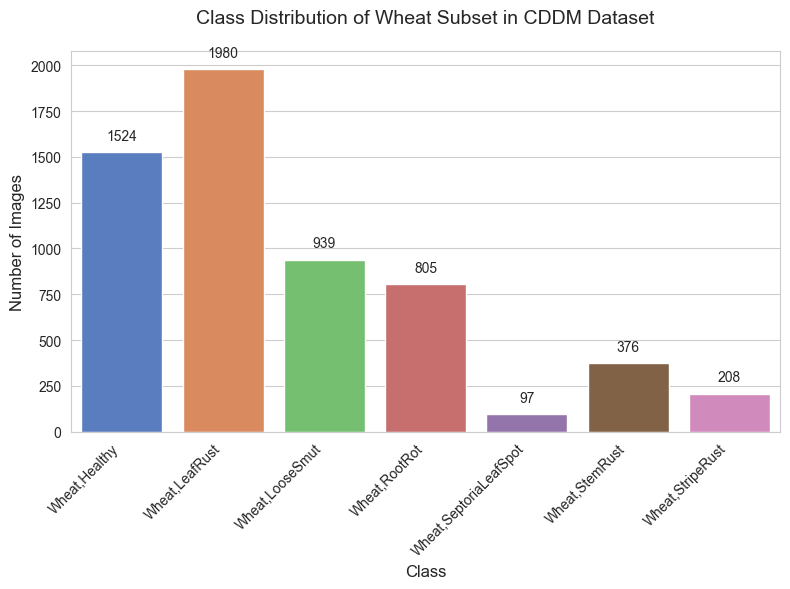

In [17]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better visualization using Seaborn
sns.set_style("whitegrid")  # Use Seaborn's whitegrid style for a professional look
sns.set_palette("muted")    # Use a muted color palette for clarity

# Define the dataset path
DATASET_PATH = Path("../data/CDDM-images/images")
print(f"Dataset path: {DATASET_PATH}")
print(f"Exists: {DATASET_PATH.exists()}")

# Dynamically generate classes from folder names
CLASSES = [folder.name for folder in DATASET_PATH.iterdir() if folder.is_dir()]

# Filter for Wheat classes only
CLASSES = [cls for cls in CLASSES if cls.startswith("Wheat,")]
CLASSES.sort()  # Sort for consistency
print(f"Classes: {CLASSES}")

if not CLASSES:
    raise ValueError("No classes found for Wheat. Check the dataset path and folder names.")

# Calculate the number of images per class
class_counts = {}
for cls in CLASSES:
    class_path = os.path.join(DATASET_PATH, cls)
    num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[cls] = num_images

# Calculate total number of images
total_images = sum(class_counts.values())
print(f"Total number of images: {total_images}")

# Verify the total matches the expected number
if total_images != 5929:
    print(f"Warning: Total images ({total_images}) do not match expected total (5929). Please verify dataset.")

# Prepare data for plotting
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a vertical bar chart using matplotlib and seaborn
plt.figure(figsize=(8, 6))  # Set figure size for readability
bars = sns.barplot(x=class_names, y=counts, hue=class_names, palette="muted", legend=False)

# Add labels and title
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution of Wheat Subset in CDDM Dataset", fontsize=14, pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the count on top of each bar
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50,  # Place text above the bar
             f'{counts[i]}', 
             ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot as a high-quality image for inclusion in the report
plt.savefig("wheat_class_distribution_vertical.png", dpi=300, bbox_inches='tight')
print("Vertical bar chart saved as 'wheat_class_distribution_vertical.png'")

# Display the plot
plt.show()

# Model and Processor Loading

Objective: Load the Qwen2.5-VL-3B-Instruct model and its processor from the local directory.

Here, we set up the model for inference.

In [5]:
# Define local model directory
local_dir = "../models/qwen2_5_vl_3b_instruct"

# Load processor and model
processor = AutoProcessor.from_pretrained(local_dir, use_fast=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    local_dir,
    device_map="auto",
    torch_dtype=torch.float16,
).eval()

print("Model and processor loaded successfully.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Model and processor loaded successfully.


In [6]:
# Verify model device
model_device = next(model.parameters()).device
print(f"Model is on device: {model_device}")

Model is on device: cuda:0


## Function Definition: Multi-Turn Conversational Inference

The following cell defines the `vqa_inference_multi_turn` function, which performs multi-turn conversational inference using the Qwen2.5-VL-3B-Instruct model. This function is designed to handle a sequence of questions about an image, mirroring the conversational style presented in the CDDM dataset paper (Page 2), where the model identifies a plant, diagnoses any issues, and provides prevention/control methods.

In [7]:
def vqa_inference_multi_turn(image_path, questions, model, processor, device, max_new_tokens=150, resize_resolution=224):
    """
    Perform multi-turn conversational inference with Qwen2.5-VL-3B-Instruct.
    
    Args:
        image_path (str): Path to the input image.
        questions (list): List of questions for the multi-turn conversation.
        model: Qwen2.5-VL-3B-Instruct model.
        processor: Qwen2.5-VL-3B-Instruct processor.
        device: Device to run the model on (e.g., 'cuda').
        max_new_tokens (int): Maximum number of tokens to generate per response.
        resize_resolution (int): Resolution to resize the image to (default: 224).
    
    Returns:
        list: List of responses for each question, or None if an error occurs.
    """
    # Load and resize the image
    try:
        image = Image.open(image_path).convert("RGB")
        # Resize image to reduce memory usage
        image = image.resize((resize_resolution, resize_resolution), Image.Resampling.LANCZOS)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

    # Initialize conversation history
    conversation = []
    responses = []

    # Process each question in the multi-turn conversation
    for i, question in enumerate(questions):
        if i == 0:
            # First turn includes the image
            conversation.append({
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": question},
                ]
            })
        else:
            # Subsequent turns use text only, relying on history
            conversation.append({
                "role": "user",
                "content": [
                    {"type": "text", "text": question},
                ]
            })

        # Process the conversation
        try:
            inputs = processor.apply_chat_template(
                conversation,
                add_generation_prompt=True,
                tokenize=True,
                return_dict=True,
                return_tensors="pt"
            )
            inputs = inputs.to(device)
        except Exception as e:
            print(f"Error processing conversation at turn {i+1}: {e}")
            return None

        # Generate the output
        try:
            with torch.no_grad():
                output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
        except Exception as e:
            print(f"Error generating response at turn {i+1}: {e}")
            return None

        # Trim and decode the output
        generated_ids = [
            output_ids[i][len(inputs.input_ids[i]):] for i in range(len(output_ids))
        ]
        output_text = processor.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )[0]

        # Add the assistant's response to the conversation
        conversation.append({
            "role": "assistant",
            "content": [
                {"type": "text", "text": output_text},
            ]
        })
        responses.append(output_text)

    # Clear memory after processing
    torch.cuda.empty_cache()
    return responses

## Sample Image Analysis

To evaluate the Qwen2.5-VL-3B-Instruct model's performance in crop disease diagnosis, we analyze four images from the wheat dataset, representing a mix of healthy and diseased conditions. For each image, we perform a multi-turn conversation to assess the model's ability to:
1. Identify the plant.
2. Diagnose any issues (e.g., healthy or diseased).
3. Provide prevention and control methods.

This approach mirrors the conversational style in the CDDM dataset paper (Page 2), where the model answers questions like "What is this plant?", "What’s wrong with this plant?", and "How to prevent and control [disease]?".

### Image 1: Healthy Wheat
![Figure 1: Healthy wheat leaf.](../data/CDDM-images/images/Wheat,Healthy/plant_131164.jpg)

### Image 2: Wheat with Leaf Rust
![Figure 2: Wheat leaf with leaf rust.](../data/CDDM-images/images/Wheat,LeafRust/plant_132728.jpg)

### Image 3: Wheat with Stripe Rust
![Figure 3: Wheat leaf with stripe rust.](../data/CDDM-images/images/Wheat,StripeRust/plant_136180.jpg)

### Image 4: Wheat with Septoria Leaf Spot
![Figure 4: Wheat leaf with septoria leaf spot.](../data/CDDM-images/images/Wheat,SeptoriaLeafSpot/plant_135644.jpg)

In [ ]:
# Define the images and questions
image_data = [
    {
        "path": "../data/CDDM-images/images/Wheat,Healthy/plant_131164.jpg",
        "description": "Healthy Wheat",
        "questions": [
            "What is this plant?",
            "What’s wrong with this plant?",
            "How to prevent and control wheat disease?"
        ]
    },
    {
        "path": "../data/CDDM-images/images/Wheat,LeafRust/plant_132728.jpg",
        "description": "Wheat with Leaf Rust",
        "questions": [
            "What is this plant?",
            "What’s wrong with this plant?",
            "How to prevent and control wheat leaf rust?"
        ]
    },
    {
        "path": "../data/CDDM-images/images/Wheat,StripeRust/plant_136180.jpg",
        "description": "Wheat with Stripe Rust",
        "questions": [
            "What is this plant?",
            "What’s wrong with this plant?",
            "How to prevent and control wheat stripe rust?"
        ]
    },
    {
        "path": "../data/CDDM-images/images/Wheat,SeptoriaLeafSpot/plant_135644.jpg",
        "description": "Wheat with Septoria Leaf Spot",
        "questions": [
            "What is this plant?",
            "What’s wrong with this plant?",
            "How to prevent and control wheat septoria leaf spot?"
        ]
    }
]

# Open a file to save results
with open("inference_results.txt", "w") as f:
    # Perform inference for each image
    for idx, data in enumerate(image_data, 1):
        f.write(f"\n### Analysis for Image {idx}: {data['description']}\n")
        f.write(f"Image Path: {data['path']}\n")
        print(f"\n### Analysis for Image {idx}: {data['description']}")
        print(f"Image Path: {data['path']}")
        
        # Run the multi-turn conversation
        responses = vqa_inference_multi_turn(
            image_path=data["path"],
            questions=data["questions"],
            model=model,
            processor=processor,
            device=device,
            max_new_tokens=150,
            resize_resolution=224
        )
        
        # Print and save the conversation
        if responses:
            for i, (question, response) in enumerate(zip(data["questions"], responses), 1):
                f.write(f"\nTurn {i}:\n")
                f.write(f"Question: {question}\n")
                f.write(f"Model Answer: {response}\n")
                print(f"\nTurn {i}:")
                print(f"Question: {question}")
                print(f"Model Answer: {response}")
        else:
            f.write("Inference failed. Check the error messages above.\n")
            print("Inference failed. Check the error messages above.")

## Analysis of Model Responses

The Qwen2.5-VL-3B-Instruct model was evaluated on four wheat images with different conditions: healthy, leaf rust, stripe rust, and septoria leaf spot. Below, we analyze its performance across the three tasks: plant identification, disease diagnosis, and prevention/control recommendations. The inference was run with `max_new_tokens=150` to obtain more complete responses, though some answers still cut off slightly due to the token limit.

### Plant Identification
- **Image 1 (Healthy Wheat)**: The model incorrectly identified the plant as a type of grass (rye grass or fescue) instead of wheat, indicating a lack of agricultural specificity despite describing leaf characteristics.
- **Image 2 (Wheat with Leaf Rust)**: The model did not identify the plant, instead focusing on the disease (*Puccinia graminis*), showing a misunderstanding of the question. It mentioned wheat as a possible host but did not explicitly identify the plant.
- **Image 3 (Wheat with Stripe Rust)**: Similar to Image 2, the model focused on the disease (*Puccinia graminis*) rather than identifying the plant as wheat, though it listed wheat as a possible host.
- **Image 4 (Wheat with Septoria Leaf Spot)**: The model described symptoms (yellowish-brown spots) and possible causes instead of identifying the plant as wheat, missing the question’s intent.

### Disease Diagnosis
- **Image 1 (Healthy Wheat)**: The model correctly identified the plant as healthy, noting no visible signs of disease, pests, or damage. This is a significant improvement over the previous run, where it hallucinated leaf spot disease.
- **Image 2 (Wheat with Leaf Rust)**: The model misdiagnosed leaf rust as *Puccinia graminis* (stem rust), whereas leaf rust is caused by *Puccinia triticina*. It correctly noted yellowish spots but described a darker halo, which is more typical of stem rust than leaf rust.
- **Image 3 (Wheat with Stripe Rust)**: The model misdiagnosed stripe rust as *Puccinia graminis* (stem rust), whereas stripe rust is caused by *Puccinia striiformis*. The orange/brown spots were correctly identified as a symptom, but the diagnosis was incorrect.
- **Image 4 (Wheat with Septoria Leaf Spot)**: The model suggested a fungal infection (leaf spot disease) as a possible cause, which is partially correct since septoria leaf spot is a fungal disease (*Septoria tritici*). However, it didn’t specifically diagnose septoria leaf spot, listing other possibilities like nutrient deficiency and environmental stress, and failed to describe characteristic symptoms like dark spots with grayish-white centers.

### Prevention and Control Recommendations
- **Image 1 (Healthy Wheat)**: The model provided general prevention methods for wheat diseases, including crop rotation, soil management, and planting practices (e.g., appropriate seeding dates). These are relevant for a healthy plant but cut off before fully detailing the seeding date strategy.
- **Image 2 (Wheat with Leaf Rust)**: The model recommended crop rotation, resistant varieties, and early detection with fungicide application, which are valid methods for leaf rust. However, it incorrectly attributed leaf rust to *Puccinia graminis*. The response cut off before detailing fungicide specifics.
- **Image 3 (Wheat with Stripe Rust)**: The model suggested crop rotation, genetic resistance, early detection, and soil management, which are relevant for stripe rust. It misattributed stripe rust to *Puccinia graminis* and cut off before detailing control methods (e.g., fungicides).
- **Image 4 (Wheat with Septoria Leaf Spot)**: The model provided prevention methods including crop rotation, soil management, early detection, and disease-resistant varieties, which are appropriate for septoria leaf spot. The response cut off before discussing control methods like fungicide application.

### Performance Summary
| Image                  | Plant Identification       | Disease Diagnosis           | Prevention/Control Relevance |
|------------------------|----------------------------|-----------------------------|------------------------------|
| Healthy Wheat          | Incorrect (Rye grass/Fescue) | Correct (Healthy)          | Relevant (General methods)   |
| Wheat with Leaf Rust   | Not identified (Focused on disease) | Incorrect (*Puccinia graminis*) | Relevant (Standard practices) |
| Wheat with Stripe Rust | Not identified (Focused on disease) | Incorrect (*Puccinia graminis*) | Relevant (Standard practices) |
| Wheat with Septoria Leaf Spot | Not identified (Focused on symptoms) | Partially Correct (Fungal infection) | Relevant (Standard practices) |

### Overall Assessment
The Qwen2.5-VL-3B-Instruct model struggles with plant identification, failing to recognize wheat in all four images and either misidentifying the plant (e.g., as rye grass or fescue) or focusing on symptoms/diseases instead of answering the question. This indicates a lack of agricultural knowledge, likely due to the absence of fine-tuning on a specialized dataset like CDDM, which the paper used to achieve 97.4% crop classification accuracy with Qwen-VL-Chat-AG (Table 1, Page 11). The base Qwen-VL-Chat model in the paper also performed poorly without fine-tuning (28.4% crop classification accuracy), suggesting that Qwen2.5-VL-3B-Instruct’s performance is consistent with an un-fine-tuned vision-language model.

Disease diagnosis shows mixed results: the model correctly identified the healthy wheat plant, a significant improvement over the previous run, but misdiagnosed leaf rust and stripe rust as *Puccinia graminis* (stem rust) and only partially identified septoria leaf spot as a fungal infection without specific diagnosis. These errors highlight the model’s limited understanding of wheat-specific diseases.

The prevention and control recommendations are relevant and more detailed with `max_new_tokens=150`, including standard practices like crop rotation, resistant varieties, early detection, and soil management. However, the responses often cut off before providing control methods (e.g., specific fungicides), which the paper’s fine-tuned model includes (Page 2). The recommendations are practical but lack the specificity of a fine-tuned model.

Future work should focus on fine-tuning the model on the wheat dataset, using more powerful hardware to enable longer responses, and implementing dynamic questioning to tailor prevention/control questions to the model’s diagnosis.

## Prepare the Test Set for Baseline Evaluation

The following cell creates a test set for baseline evaluation by selecting a subset of images from each class in the wheat dataset. The CDDM dataset paper (Page 11) evaluated the base Qwen-VL-Chat model on a test split to compute metrics like crop classification accuracy (28.4%, Table 1). We select 20 images per class, totaling 80 images across four classes, which is a reasonable estimate for a test split based on standard practices and the paper’s balanced dataset (Page 5).

In [8]:
# Define the dataset directory
dataset_dir = "../data/CDDM-images/images/"

# Define the classes
classes = ["Wheat,Healthy", "Wheat,LeafRust", "Wheat,StripeRust", "Wheat,SeptoriaLeafSpot"]

# Initialize the test set
test_set = []
images_per_class = 20  # Number of images per class for evaluation

# Check the number of images per class and collect images
for class_name in classes:
    image_paths = glob(os.path.join(dataset_dir, class_name, "*.jpg"))
    print(f"Class {class_name}: {len(image_paths)} images available.")
    if len(image_paths) < images_per_class:
        print(f"Warning: Only {len(image_paths)} images available for {class_name}. Using all available images.")
        selected_images = image_paths
    else:
        selected_images = random.sample(image_paths, images_per_class)
    
    for image_path in selected_images:
        test_set.append({
            "image_path": image_path,
            "class": class_name,
            "questions": [
                "What is this plant?",
                "What’s wrong with this plant?",
                f"How to prevent and control wheat {class_name.split(',')[1].lower().replace('leaf', ' leaf ').replace('stripe', 'stripe ')}?" if class_name != "Wheat,Healthy" else "How to prevent and control wheat disease?"
            ]
        })

# Save the test set to a JSON file
with open("test_set.json", "w") as f:
    json.dump(test_set, f, indent=4)

print(f"Created test set with {len(test_set)} images.")

Class Wheat,Healthy: 1524 images available.
Class Wheat,LeafRust: 1980 images available.
Class Wheat,StripeRust: 208 images available.
Class Wheat,SeptoriaLeafSpot: 97 images available.
Created test set with 80 images.


## Quantitative Baseline Evaluation

The following cell evaluates the un-fine-tuned Qwen2.5-VL-3B-Instruct model on the test set to compute quantitative metrics, such as plant identification accuracy and disease diagnosis accuracy. This mirrors the evaluation in the CDDM dataset paper (Page 11), where the authors reported a crop classification accuracy of 28.4% for the base Qwen-VL-Chat model (Table 1). The test set contains 20 images per class (or fewer if limited by the dataset), totaling [to be updated] images, which is a reasonable estimate based on the paper’s balanced dataset and standard test split practices (Page 5).

In [9]:
# Load the test set
with open("test_set.json", "r") as f:
    test_set = json.load(f)

# Initialize counters for metrics
plant_correct = 0
disease_correct = 0
total = len(test_set)

# Evaluate each image in the test set
for item in tqdm(test_set, desc="Evaluating test set"):
    image_path = item["image_path"]
    class_name = item["class"]
    condition = class_name.split(",")[1]  # e.g., "Healthy", "LeafRust"
    questions = item["questions"]

    # Run inference
    responses = vqa_inference_multi_turn(
        image_path=image_path,
        questions=questions,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=150,
        resize_resolution=224
    )

    if not responses:
        print(f"Failed to process {image_path}. Skipping.")
        total -= 1
        continue

    # Evaluate plant identification (Turn 1)
    plant_answer = responses[0].lower()
    if "wheat" in plant_answer:
        plant_correct += 1

    # Evaluate disease diagnosis (Turn 2)
    disease_answer = responses[1].lower()
    if condition == "Healthy":
        if "healthy" in disease_answer:
            disease_correct += 1
    elif condition == "LeafRust":
        if "leaf rust" in disease_answer:
            disease_correct += 1
    elif condition == "StripeRust":
        if "stripe rust" in disease_answer:
            disease_correct += 1
    elif condition == "SeptoriaLeafSpot":
        if "septoria leaf spot" in disease_answer:
            disease_correct += 1

# Compute accuracies
plant_accuracy = (plant_correct / total) * 100 if total > 0 else 0
disease_accuracy = (disease_correct / total) * 100 if total > 0 else 0

print(f"Plant Identification Accuracy: {plant_accuracy:.2f}% ({plant_correct}/{total})")
print(f"Disease Diagnosis Accuracy: {disease_accuracy:.2f}% ({disease_correct}/{total})")

# Save the metrics
with open("baseline_metrics.json", "w") as f:
    json.dump({
        "plant_identification_accuracy": plant_accuracy,
        "disease_diagnosis_accuracy": disease_accuracy,
        "total_samples": total
    }, f, indent=4)

Evaluating test set: 100%|██████████| 80/80 [5:14:18<00:00, 235.74s/it]  

Plant Identification Accuracy: 51.25% (41/80)
Disease Diagnosis Accuracy: 18.75% (15/80)
